In [1]:
import networkx as nx
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def golden_figsize(height):
    """
    Assuming height dimension is the shorter one, the width should be:
    (1 + 5**0.5)/2
    
    This function thus returns the (width, height) tuple which is
    computed to be in a golden ratio.
    """
    width = height * (1 + 5**0.5) / 2
    return (width, height)

In [3]:
G = nx.read_gpickle('20141103 All IRD Final Graph.pkl')

In [5]:
# Add in ecotype information

# Load the data
df = pd.read_csv('Country-Species_coded.csv', index_col=0)
df['Habitat/setting'] = df['Habitat/setting'].replace('Domestic ', 'Domestic')
# Make it into a dicitonary where each entry is (country, species):habitat/setting
ecotype_map = dict()

for row, data in df.iterrows():
    country = data['Country']
    species = data['Species']
    ecotype = data['Habitat/setting']

    ecotype_map[(country, species)] = ecotype

# Add the ecotype into each node.
for n, d in G.nodes(data=True):
    country = d['country']
    species = d['host_species']
    if '/' in species:
        species = species.split('/')[0]
    if 'null' in species:
        species = 'Unknown'


    
    G.node[n]['ecotype'] = ecotype_map[(country, species)]

In [6]:
def correct_metadata(G, node):
    """
    Helper function for providing the correct subtype graph metadata.    
    """
    d = G.node[node]
    subtype = d['subtype']
    ecotype = d['ecotype']
    host = d['host_species']
    if ecotype == 'Unknown':
        ecotype = 'W'
    if host == 'Human':
        ecotype = 'H'
    if ecotype == 'Domestic':
        ecotype = 'D'
    if ecotype == 'Wild':
        ecotype = 'W'
    subtype = subtype + '_' + ecotype
    
    return ecotype, subtype, host
    

In [7]:
from collections import Counter
tcounter = Counter()
# Plot the number of ecotype jumps detected.
for sc, sk, d in G.edges(data=True):
    if d['edge_type'] == 'reassortant':
        sc_ecotype, sc_subtype, sc_host = correct_metadata(G, sc)
        sk_ecotype, sk_subtype, sk_host = correct_metadata(G, sk)

        transition = sc_ecotype + '::' + sk_ecotype
        tcounter[transition] += 1

In [8]:
tcounter

Counter({'W::W': 3581, 'D::D': 906, 'W::D': 486, 'D::H': 399, 'D::W': 220, 'H::H': 123, 'H::D': 122, 'W::H': 70, 'H::W': 2})

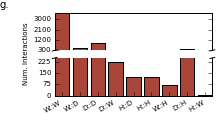

In [9]:
# Plot the data as a bar graph, using the same order as in the Intersubtype Interactions at Ecotype Interfaces
"""
Order desired:
1. Wild->Wild
2. Wild->Domestic
3. Domestic->Domestic
4. Domestic->Wild
5. Human->Domestic
6. Human->Human
7. Wild->Human
8. Domestic->Human
9. Human->Wild
"""
data_order = ['W::W',
              'W::D',
              'D::D',
              'D::W',
              'H::D',
              'H::H',
              'W::H',
              'D::H',
              'H::W']

bar_heights = [tcounter[i] for i in data_order]
xs = [i for i, n in enumerate(bar_heights)]

fig = plt.figure(figsize=(3, 1.5))
ax1 = fig.add_subplot(1,1,1) #background ax
ax2 = fig.add_subplot(2,1,1) #top ax
ax3 = fig.add_subplot(2,1,2) #bottom ax

# Set unnecessary things to be invisible.
ax1.xaxis.set_visible(False)
ax1.yaxis.set_ticks([])
ax2.xaxis.set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax3.spines['top'].set_visible(False)

# Set plotting parameters
ax3.set_xticks(np.arange(0, len(xs)))
ax2.set_xticks(np.arange(0, len(xs)))
ax3.xaxis.set_ticklabels(data_order, rotation=30, ha='right')
ax2.xaxis.tick_top()
ax3.xaxis.tick_bottom()

# Set the y-limits on top and bottom plots
ax2.set_ylim(300, 3601)
ax2.set_yticks(np.arange(300, 3601, 900))
ax3.set_ylim(0, 250)
ax3.set_yticks(np.arange(0, 251, 75))

# Plot the bar charts
import matplotlib.colors as colors
ax2.bar(xs, bar_heights, align='center', color=colors.hex2color('#AA4639'))
ax3.bar(xs, bar_heights, align='center', color=colors.hex2color('#AA4639'))

# Add in diagonal lines
d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax2.transAxes, color='k', clip_on=False)
ax2.plot((-d,+d),(-d,+d), **kwargs)      # bottom-left diagonal
ax2.plot((1-d,1+d),(-d,+d), **kwargs)    # bottom-right diagonal

kwargs.update(transform=ax3.transAxes)  # switch to the bottom axes
ax3.plot((-d,+d),(1-d,1+d), **kwargs)   # top-left diagonal
ax3.plot((1-d,1+d),(1-d,1+d), **kwargs) # top-right diagonal
ax1.set_ylabel('Num. Interactions\n\n\n')
# ax2.set_title('Ecotype Interaction Counts')

ax1.annotate('g.', xy=(0,1), xycoords='figure fraction', va='top', ha='left')
plt.subplots_adjust(left=0.22, right=0.95, bottom=0.18, top=0.95)
plt.savefig('Ecotype Interaction Counts.pdf')

In [10]:
# Of interest are the reverse zoonosis events, where human ecotype jumps back into wild or domestic animal ecotype.
# What's the list of such ecotype jumps?

rz_events = [] # reverse zoonosis events
rz_subtypes = [] # subtypes involved in reverse_zoonosis
rz_hosts = [] # hosts involved in reverse zoonosis
rz_dates = [] # time stamps involved in reverse zoonosis
rz_timedeltas = [] # time deltas in reverse zoonosis

for sc, sk, d in G.edges(data=True):
    sc_ecotype, sc_subtype, sc_host = correct_metadata(G, sc)
    sk_ecotype, sk_subtype, sk_host = correct_metadata(G, sk)
    
    sc_date = G.node[sc]['collection_date']
    sk_date = G.node[sk]['collection_date']
    
    if sc_ecotype == 'H' and sk_ecotype != 'H':
        rz_events.append((sc, sk))
        rz_subtypes.append((sc_subtype, sk_subtype))
        rz_hosts.append((sc_host, sk_host))
        rz_dates.append((sc_date, sk_date))
        rz_timedeltas.append(sk_date - sc_date)

In [11]:
Counter(rz_hosts)

Counter({('Human', 'Swine'): 640, ('Human', 'Chicken/Avian'): 33, ('Human', 'Duck/Avian'): 10, ('Human', 'Dog'): 8, ('Human', 'Environment'): 7, ('Human', 'Pigeon/Avian'): 4, ('Human', 'Muscovy Duck/Avian'): 3, ('Human', 'Green-Winged Teal/Avian'): 3, ('Human', 'Turkey/Avian'): 2, ('Human', 'null'): 2, ('Human', 'Mallard/Avian'): 2, ('Human', 'Ferret'): 1, ('Human', 'Panda'): 1, ('Human', 'Goose/Avian'): 1, ('Human', 'Little Egret/Avian'): 1, ('Human', 'Grey Heron/Avian'): 1})

(array([ 584.,   93.,   25.,    2.,    5.,    2.,    2.,    1.,    1.,    4.]),
 array([  1.00000000e+00,   6.60300000e+02,   1.31960000e+03,
          1.97890000e+03,   2.63820000e+03,   3.29750000e+03,
          3.95680000e+03,   4.61610000e+03,   5.27540000e+03,
          5.93470000e+03,   6.59400000e+03]),
 <a list of 10 Patch objects>)

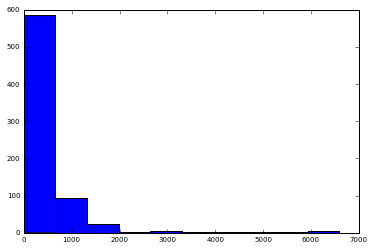

In [12]:
plt.hist([i.days for i in rz_timedeltas])

In [13]:
Counter(rz_subtypes)

Counter({('H1N1_H', 'H1N1_D'): 555, ('H3N2_H', 'H3N2_D'): 38, ('H5N1_H', 'H5N1_D'): 24, ('H1N1_H', 'H1N2_D'): 22, ('H7N9_H', 'H7N9_D'): 19, ('H1N1_H', 'H3N2_D'): 19, ('H7N9_H', 'H7N9_W'): 9, ('H1N1_H', 'H3N1_D'): 8, ('H5N1_H', 'H5N1_W'): 7, ('H1N2_H', 'H1N2_D'): 3, ('H7N9_H', 'H9N9_D'): 3, ('H3N2_H', 'H1N2_D'): 3, ('H1N1_H', 'H1N1_W'): 3, ('H1N2_H', 'H1N1_D'): 2, ('H7N3_H', 'H3N8_W'): 2, ('H1N1_H', 'H9N2_D'): 1, ('H9N2_H', 'H9N2_D'): 1})

In [14]:
def correct_ecotype(G, node):
    ecotype = G.node[node]['ecotype']
    host = G.node[node]['host_species']
    
    if ecotype in ['Unknown', 'unknown']:
        ecotype = 'Wild'
    if host == 'Human':
        ecotype = 'Human'
    return ecotype

208


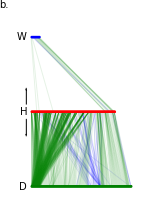

In [15]:
# Let's create a figure for this. The figure will be a 2" x 3" panel, highlighting only the reverse zoonosis events.
# The nodes on the left will be wild animal isolates, and the nodes on the right will be domestic animal isolates.
# Human nodes will take the center portion.

# The nodes will be colored in the same way as on the hive plots: red for human, green for domestic animals, and blue for 
# wild animal.

# The edges will be colored in the same way as on the hive plots: blue for different subtype interactions, and green for #
# same subtype interactions.

fig = plt.figure(figsize=(2,3))
ax = fig.add_subplot(111)

nodes = dict()
nodes['Wild'] = []
nodes['Human'] = []
nodes['Domestic'] = []

edges = dict()
edges['Human-Wild'] = []
edges['Human-Domestic'] = []

for sc, sk, d in G.edges(data=True):
    
    sc_ecotype = correct_ecotype(G, sc)
    sk_ecotype = correct_ecotype(G, sk)
    
    if sc_ecotype == 'Human' and sk_ecotype != 'Human':
    
        if sc not in nodes[sc_ecotype]:
            nodes[sc_ecotype].append(sc)
        if sk not in nodes[sk_ecotype]:
            nodes[sk_ecotype].append(sk)
    
        ecotype_transition = '{0}-{1}'.format(sc_ecotype, sk_ecotype)
        
        edges[ecotype_transition].append((sc, sk))

# Sort the items by subtype
for k, v in nodes.items():
    nodes[k] = sorted(v, key=lambda x:G.node[x]['subtype'])
    
# Scale factor
scale = 2
maxnum = max([len(v) for k, v in nodes.items()])
node_radius = 1
print(maxnum)

# Wild goes on top
ax.set_xlim(-12*node_radius, maxnum + node_radius + 10)
ax.set_ylim(-12*node_radius, maxnum + node_radius + 10)
for i, node in enumerate(nodes['Wild']):
    xpos = float(i + 1)
    ypos = maxnum - node_radius
    c = plt.Circle(xy=(xpos, ypos), radius=node_radius, color='blue')
    ax.add_patch(c)
    
# Next comes Humans
for i, node in enumerate(nodes['Human']):
    xpos = float(i + 1)
    ypos = maxnum * 0.5
    c = plt.Circle(xy=(xpos, ypos), radius=node_radius, color='red')
    ax.add_patch(c)
    
# Finally comes Domestic animals
for i, node in enumerate(nodes['Domestic']):
    xpos = float(i + 1)
    ypos = node_radius
    c = plt.Circle(xy=(xpos, ypos), radius=node_radius, color='green')
    ax.add_patch(c)

# Plot each edge as a straight line.
for tset, edgelist in edges.items():
    if tset == 'Human-Wild':
        ys = [maxnum*0.5, maxnum-node_radius]
    if tset == 'Human-Domestic':
        ys = [maxnum*0.5, node_radius]
        
    for edge in edgelist:
        sc, sk = edge
        if tset == 'Human-Wild':
            xs = [nodes['Human'].index(sc), nodes['Wild'].index(sk)]
        if tset == 'Human-Domestic':
            xs = [nodes['Human'].index(sc), nodes['Domestic'].index(sk)]
        sc_subtype = G.node[sc]['subtype']
        sk_subtype = G.node[sk]['subtype']

        if sc_subtype == sk_subtype:
            color='green'
        else:
            color='blue'

        plt.plot(xs, ys, color=color, alpha=0.1, zorder=0)

# Annotate in the W, H or D labels to the left of each axis.
ax.annotate('W', xy=(-10*node_radius, maxnum-node_radius), xycoords='data', ha='right', va='center')
ax.annotate('H', xy=(-10*node_radius, maxnum*0.5), xycoords='data', ha='right', va='center')
ax.annotate('D', xy=(-10*node_radius, node_radius), xycoords='data', ha='right', va='center')

# Add in two arrows to indicate the flow of sequences.
ax.arrow(-10,maxnum*0.5+10, 0,maxnum*1/10, fc='k', ec='k', head_width=node_radius*2, head_length=node_radius*3, lw=node_radius/float(2))
ax.arrow(-10,maxnum*0.5-10, 0,-maxnum*1/10, fc='k', ec='k', head_width=node_radius*2, head_length=node_radius*3, lw=node_radius/float(2))

# Annotate the sub-figure letter.
ax.annotate('b.', xy=(0,1), xycoords='figure fraction', ha='left', va='top')

# Remove all spines from the axes object, and set x/y-ticks to be absent.
for spine in ax.spines.keys():
    ax.spines[spine].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
    
plt.savefig('Reverse Zoonosis.pdf')